In [28]:
import pandas as pd
import numpy as np
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [29]:
path = "/home/hasan/Desktop/FYP-II/data/AnnotatedData3.csv"

def extract (path):
    fd= open(path,encoding="utf-8", errors='replace')
    df = pd.read_csv(fd)   
    defined=df['class'] != ("undefined")
    # #output dataframe without undeined
    df2=df[defined]
    defined1=df2['class'] !="Undefined"
    df4=df2[defined1]
    #replace no PI with no
    df3=df4.replace("No PI","no")
    #replace PI with yes
    final=df3.replace("PI","yes")
    
    replace_yes=final.replace("Yes","yes")
    final_df= replace_yes.replace("No","no")
    return final_df, df

final_data_frame, data_frame_undefined = extract(path)

print(final_data_frame)

     class                                               text
0       no  i'll  buy  the  iphone   x  if it can  get  ac...
1       no  Some dude in FB selling the  iPhone   X  64 gb...
2      yes  Home dab emote man today and I  get  hopped on...
3      yes                               Buy  an  iPhone   X 
4       no  I hate iOS 11. My  iPhone  6+ works 10X slower...
7       no  Bo-go sale tomorrow at T-Mobile  buy  one  get...
8      yes  I can  get  the  iPhone   X  here.... If I'm w...
9      yes  When you  buy  an  Iphone   X  with Unlimited ...
10     yes  @ Mrwhosetheboss  i really  wish  i  get  to m...
11      no  @ sprint  @sprintcare  if I switch to @TMobile...
12      no  Oneplus 5t has faster face recognition than  i...
13      no  Don't  buy  an  iPhone   X  if you're ugly. I ...
14      no  Could  buy  2x 5T with the price I paid for th...
15     yes  My friend shopping:  iPhone   X  is not that e...
16     yes  What if there was upgrade to an  iPhone  8 or ...
19      

In [30]:
#creating the training and testing datasets
class_label = final_data_frame['class']
text = final_data_frame['text']

X_train, X_test, y_train, y_test = train_test_split(text, class_label, test_size=0.2, random_state=42)

In [31]:
#Cleaning the data
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
        
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)        
        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

from pandas import *
df = DataFrame({'Before': X_train, 'After': corpus})
print(df.head(20))

prediction = dict()

                                                 Before  \
39                   So in  love   w  the  iPhone   x .   
470   Bro this  iPhone X  camera quality better come...   
848   I'm the same I was on  iPhone  6 Plus and sinc...   
1172  Just ordered the  iPhone   X  but it don’t  ge...   
1758                             $1200 is a huge  deal    
489   But instead of giving out just one for example...   
268   College students complaining they're broke the...   
1369  “The  iPhone   X  is too  expensive ” “Apple d...   
836    So if you feel  iPhone   X  is expensive (it is)   
787   Someone  buy  me an  iPhone   X  cause I'm  aw...   
105            I  wish  I could  get  the  iPhone   X .   
233   What about me I'm trying to  get  that  iPhone...   
457   I got a  iPhone X /10 for sale.\n\nIt's a 6 an...   
1537                             get  the  iPhone   X ?   
987   WAIT DEAL OR NO DEAL?!!! I  HATE  COMMERCIALS ...   
792   I'm trying to  get  a man. I think it'll be ea... 

In [32]:
#Applying Multinomial Naïve Bayes learning method
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

#Applying Bernoulli Naïve Bayes learning method
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

#Applying Logistic regression learning method
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

/home/hasan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
#CONFUSION MATRIX 
#ACCURACY, PRECISON, RECALL, FSCORE

count = 0
TP = 0
FN = 0
TN = 0
FP = 0

confusion_Matrix = pd.DataFrame(data = np.zeros(shape=[4,3]) ,columns = prediction.keys(), index=['TP','FN','TN','FP'])
for column in prediction.keys():
    for values in y_test:
        if values == "yes" and prediction[column][count] == "yes":
            TP += 1
        elif values == "yes" and prediction[column][count] =="no":
            FN += 1
        elif values == "no" and prediction[column][count] =="no":
            TN += 1
        elif values == "no" and prediction[column][count] == "yes":
            FP += 1
        count += 1
        confusion_Matrix.at['TP',column] = TP
        confusion_Matrix.at['FN',column] = FN
        confusion_Matrix.at['TN',column] = TN
        confusion_Matrix.at['FP',column] = FP
    count = 0
    TP = 0
    FN = 0
    TN = 0
    FP = 0
    
print("confusion_Matrix")
print(confusion_Matrix)

def Accuracy():
    Accuracy_df = pd.DataFrame(data = np.zeros(shape=[1,3]) ,columns = prediction.keys())
    for col in confusion_Matrix.columns:
        TP = confusion_Matrix.at['TP',col]
        FP = confusion_Matrix.at['FP',col]
        FN = confusion_Matrix.at['FN',col]
        TN = confusion_Matrix.at['TN',col]
        accuracy = (TP+TN)/(TP+FP+FN+TN)
        Accuracy_df.at[0,col] = accuracy
    return Accuracy_df

print("Accuracy: ")
print(Accuracy())

confusion_Matrix
    Multinomial  Bernoulli  Logistic
TP        130.0      123.0     106.0
FN          1.0        8.0      25.0
TN          5.0       18.0      39.0
FP         66.0       53.0      32.0
Accuracy: 
   Multinomial  Bernoulli  Logistic
0     0.668317    0.69802  0.717822


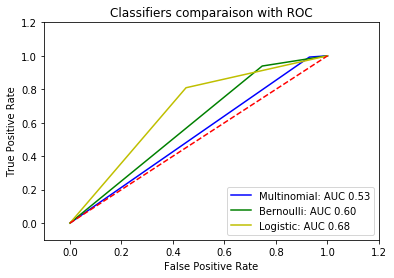

In [34]:
#ROC curve
def formatt(x):
    if x == 'no':
        return 0
    return 1

vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["yes", "no"]))

              precision    recall  f1-score   support

         yes       0.83      0.07      0.13        71
          no       0.66      0.99      0.80       131

   micro avg       0.67      0.67      0.67       202
   macro avg       0.75      0.53      0.46       202
weighted avg       0.72      0.67      0.56       202



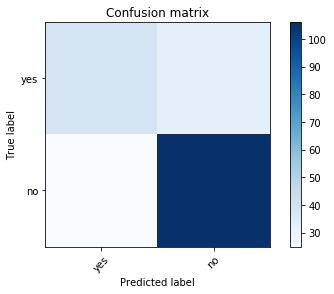

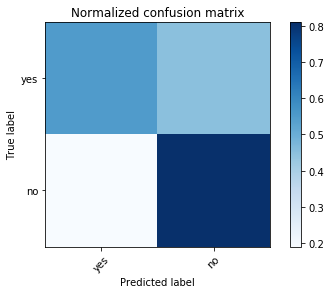

In [36]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(class_label)))
    plt.xticks(tick_marks, set(class_label), rotation=45)
    plt.yticks(tick_marks, set(class_label))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()